# HW 2.2 (Actually, it is hw 3)
## High dimensional data

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OJWRb5XakWPL_rZFYDS588ktwXViMYP7' -O hw2_q2.pkl

--2019-12-07 14:37:55--  https://docs.google.com/uc?export=download&id=1OJWRb5XakWPL_rZFYDS588ktwXViMYP7
Resolving docs.google.com (docs.google.com)... 74.125.203.101, 74.125.203.138, 74.125.203.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5bgjavs2bo2njvqb0f70iij5ogfio3b2/1575727200000/01992697873098230653/*/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7?e=download [following]
--2019-12-07 14:37:58--  https://doc-14-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5bgjavs2bo2njvqb0f70iij5ogfio3b2/1575727200000/01992697873098230653/*/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7?e=download
Resolving doc-14-4o-docs.googleusercontent.com (doc-14-4o-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-14-4o-docs.googleusercontent.com (doc-14-4o-d

In [0]:
import pickle

with open('hw2_q2.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
len(data['train'])

20000

In [0]:
len(data['test'])

6838

In [0]:
data['train'][0].shape

(32, 32, 3)

In [0]:
data.keys()

dict_keys(['train', 'test'])

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def show(img, nrow=8, interpolation='bicubic'):
  nimg = img.float()
  nimg = nimg/4
  img_grid = torchvision.utils.make_grid(nimg.permute(0, 3, 1, 2),nrow=nrow).permute(1,2,0).numpy()
  plt.figure()
  plt.imshow(img_grid, interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [0]:
train_loader = DataLoader(data['train'], batch_size=32, shuffle=True)

tensor(0.7500)


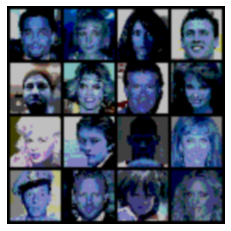

In [96]:
batch = next(iter(train_loader))
show(batch[16:32], nrow=4)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision
import torch.distributions as distributions
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetBlock(nn.Module):
    def __init__(self,channels=128):

        super(ResNetBlock,self).__init__()
        self.channels=channels

        self.network = nn.Sequential(nn.ReLU(),
          nn.Conv2d(self.channels * 2,self.channels, 1, stride=1, padding=0),
          nn.BatchNorm2d(self.channels),
          nn.ReLU(),
          nn.Conv2d(self.channels,self.channels, 3, stride=1, padding=1),
          nn.BatchNorm2d(self.channels),
          nn.ReLU(),
          nn.Conv2d(self.channels,self.channels * 2, 1, stride=1, padding=0),
          nn.BatchNorm2d(2 * self.channels)
        )

    def forward(self,x):
        out = self.network(x)
        return x + out

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, mask_config, channels, num_layers=1):
        super(AffineCoupling, self).__init__()
        self.mask_config = mask_config
        self.prior = distributions.Normal(
        torch.tensor(0.).to(device), torch.tensor(1.).to(device))

        self.layers=[nn.Conv2d(3, 2 * channels, 7, stride=1, padding=3)]
        for m in range(0, num_layers):
            self.layers.append(ResNetBlock(channels))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(2 * channels, 6, 1, 1, 0))
        
        self.network = nn.Sequential(*self.layers)
        
    def build_mask(self, size, config=1.):
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(config + mask, 2)
        mask = mask.reshape(-1, 1, size, size)
        return torch.tensor(mask.astype('float32'))
    
    def forward(self,x, reverse=False):
        x1 = x
        x_mask = self.build_mask(x.shape[2],x.shape[3]).to(device)
        _x = x*x_mask
        

        x = self.network(_x)
        log_s, t = torch.chunk(x, 2, dim=1)
        log_s *= 1 - x_mask
        t *= 1 - x_mask
        
        if reverse:       
            x = _x + (1 - x_mask) * ((x1 - t) * torch.exp(-log_s))
        else:
            x = _x + (1-x_mask)* (x1 * torch.exp(log_s) + t)
                        
        log_det = log_s.view(x1.shape[0],-1).sum(dim=1)
             
        return (x, log_det)
    
    def log_prob(self, x):
        z, log_det_J = self.forward(x, False)
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J
    
    def sample(self, size):
        z = self.prior.sample((size, 3, re_size, re_size))
        return self.forward(z, True)

In [0]:
net = AffineCoupling(1, 8).to(device)


In [127]:
batch[0:1].shape

torch.Size([1, 32, 32, 3])

In [0]:
optimizer = torch.optim.Adam(net.parameters(),lr=3e-4, weight_decay=0.0001)

In [129]:
dim_factor = torch.FloatTensor([3*32*32]).to(device)
log_factor = torch.log(torch.Tensor([2])).to(device)

loss_epoch, val_loss_epoch = [],[]

for epoch in range(5):
    losses, val_losses =[],[]
    count = 0
    for train_batch in train_loader:
        count += 1
        net.train()
        train_batch = train_batch.float().permute((0, 3, 1, 2)) / 4
        train_batch = train_batch.to(device)
        loss = -torch.mean(net.log_prob(train_batch))/dim_factor*log_factor
        losses.append(loss.data.cpu().numpy())

        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()

        if count % (100) == 0:
            print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],0))
            break

    loss_epoch.append(np.mean(losses))
    #val_loss_epoch.append(np.mean(val_losses))



Epoch 0: loss [0.44468734] val_loss 0 
Epoch 1: loss [0.26567075] val_loss 0 
Epoch 2: loss [0.14326577] val_loss 0 
Epoch 3: loss [0.11337376] val_loss 0 
Epoch 4: loss [0.02887008] val_loss 0 
